# Breast Cancer Predictive Modeling

__Import Libraries__

In [1]:
# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_palette('colorblind')


# Machine learning model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# Preprocessing and other utilities
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


__Load the data__

In [0]:
# load the data using Sklearn API
from sklearn.datasets import load_breast_cancer
bunch = load_breast_cancer()

In [3]:
bunch.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

__Custom function definition and Constants__

In [0]:
RANDOM_STATE = 42

def ecdf(arr):
    """
    Calculating Empirical Cumulative Distribution Function

    Parameters
    ----------
    arr : ndarray of shape (n,)
        Array of input

    Returns
    -------
    x, y : ndarray
        x and y are the data points used to plot ECDF 
    """

    n = arr.size
    x = np.sort(arr)
    y = np.arange(1, n + 1) / n

    return x, y


def custom_cross_val(estimator, X, y, cv=5, **kwargs):
    """
    Customize cross_val_score to fit our needs

    Parameters
    ----------
    estimator : scikit-learn estimator

    X : feature matrix

    y : target vector

    Returns
    -------
    scores : cross validation score for 5 different metrics
    """

    metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
    return { metric: cross_val_score(estimator, X, y, cv=cv, scoring=metric, **kwargs) for metric in metrics }


def prettify_scores(scores):
    """
    Print scores nicely

    Parameters
    ----------
    scores : dict
    """

    for key, val in scores.items():
        mean = np.mean(val)
        print(f"{key:10}: {val} ---> Mean : {mean}")

---

## Preliminary

For the preliminary step, we take a look again to our dataset. We will concatenate feature matrix and target vector into a single dataframe object.

In [5]:
features = pd.DataFrame(bunch.data, columns=bunch.feature_names)
features.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
target = pd.Series(np.apply_along_axis(lambda x: bunch.target_names[x], 0, bunch.target), name='target')
target.head()

0    malignant
1    malignant
2    malignant
3    malignant
4    malignant
Name: target, dtype: object

In [7]:
dataset = pd.concat([features, target], axis=1)
dataset.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


In [8]:
# how many benign and malignant
dataset.target.value_counts(normalize=True)

benign       0.627417
malignant    0.372583
Name: target, dtype: float64

Here, we get over 60% benign data points. So since our dataset is imbalanced, accuracy won't be a good metric this time. We won't use it as the main metric.

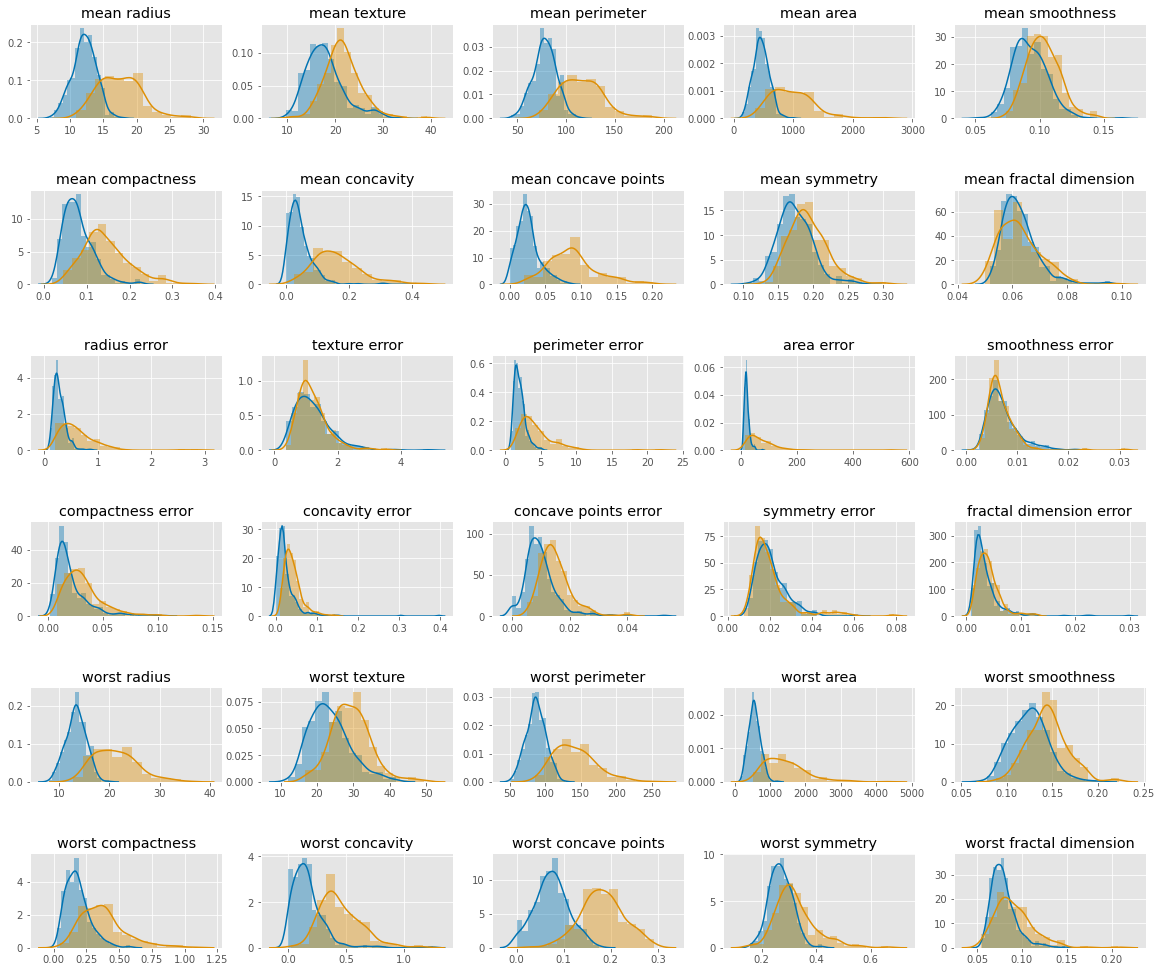

In [9]:
fig, axes = plt.subplots(6, 5, figsize=(20, 17))
fig.subplots_adjust(hspace=0.75)

for (ax, col) in zip(axes.ravel(), dataset.columns[:-1]):
    sns.distplot(dataset.loc[dataset['target'] == 'benign', col], ax=ax)
    sns.distplot(dataset.loc[dataset['target'] == 'malignant', col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')

Based on the plot above, we see that several features could classify the target pretty well independently, such as mean radius and worst concave points. Now, we will look at the empirical cumulative distribution function for each class (benign and malignant) and compare to its normal distribution.

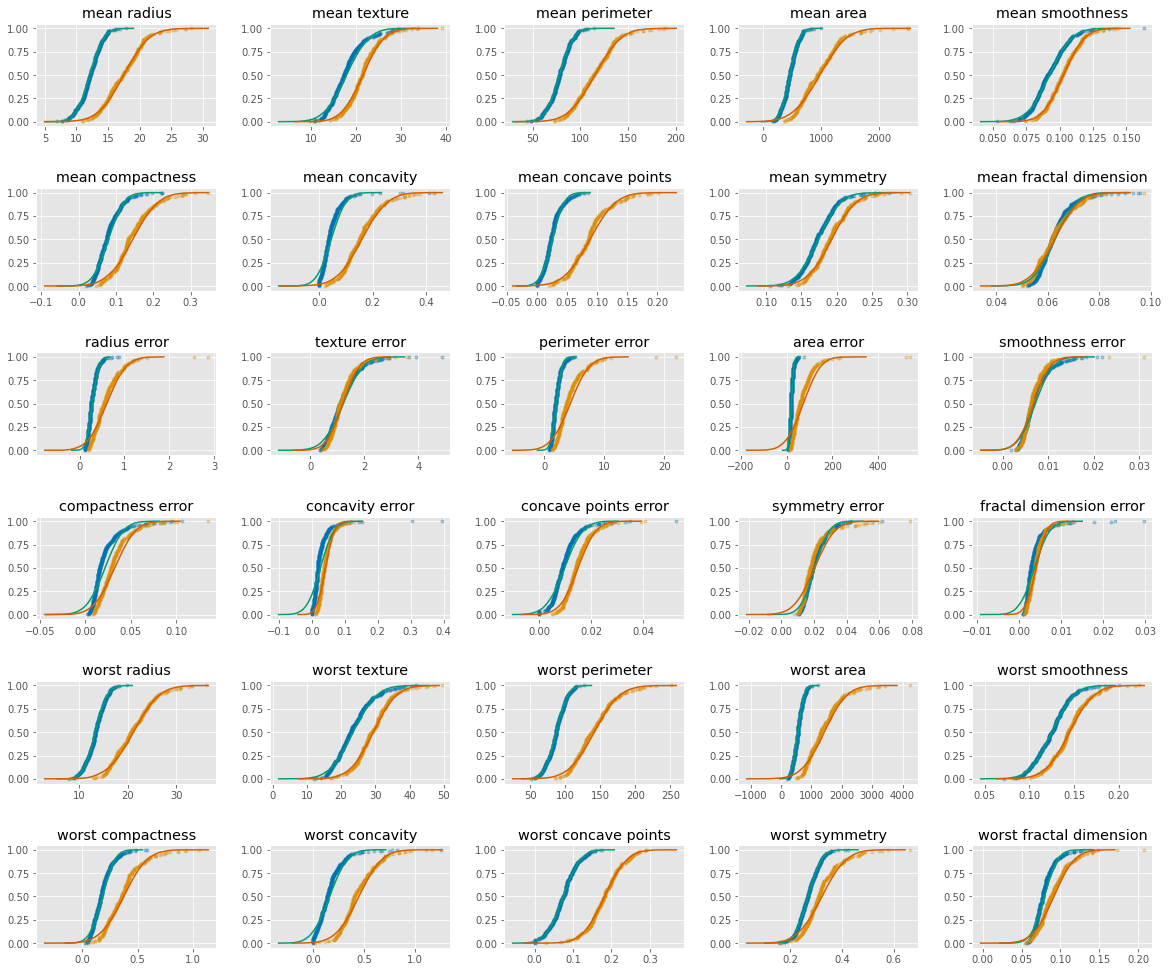

In [10]:
fig, axes = plt.subplots(6, 5, figsize=(20, 17))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for (col, ax) in zip(dataset.columns[:-1], axes.ravel()):
    n = dataset.size
    x_benign, y_benign = ecdf(dataset.loc[dataset['target'] == 'benign', col])
    x_malignant, y_malignant = ecdf(dataset.loc[dataset['target'] == 'malignant', col])
    normal_benign = np.random.normal(x_benign.mean(), x_benign.std(), size=n)
    normal_malignant = np.random.normal(x_malignant.mean(), x_malignant.std(), size=n)
    x_norm_benign, y_norm_benign = ecdf(normal_benign)
    x_norm_malignant, y_norm_malignant = ecdf(normal_malignant)
    ax.plot(x_benign, y_benign, '.', alpha=0.3)
    ax.plot(x_malignant, y_malignant, '.', alpha=0.3)
    ax.plot(x_norm_benign, y_norm_benign)
    ax.plot(x_norm_malignant, y_norm_malignant)
    ax.set_title(col)

Here, we get the empirical cumulative distribution function for each column seperated for each class. Compare to the histrogram before, we see which column that have the same distribution for benign and malignant, which means that it probably won't be a good feature for our predictors. So, if we want to eliminate several features to prevent the curse of dimensionality, we will choose these features. Until then, let's keep it untouch.

What about the correlation between features. How strong each feature related to each other.

In [11]:
correlation = dataset.iloc[:, :-1].corr()
correlation

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


Certainly hard to read all of the information above in a huge table. Better to visualize it with seaborn heatmap.

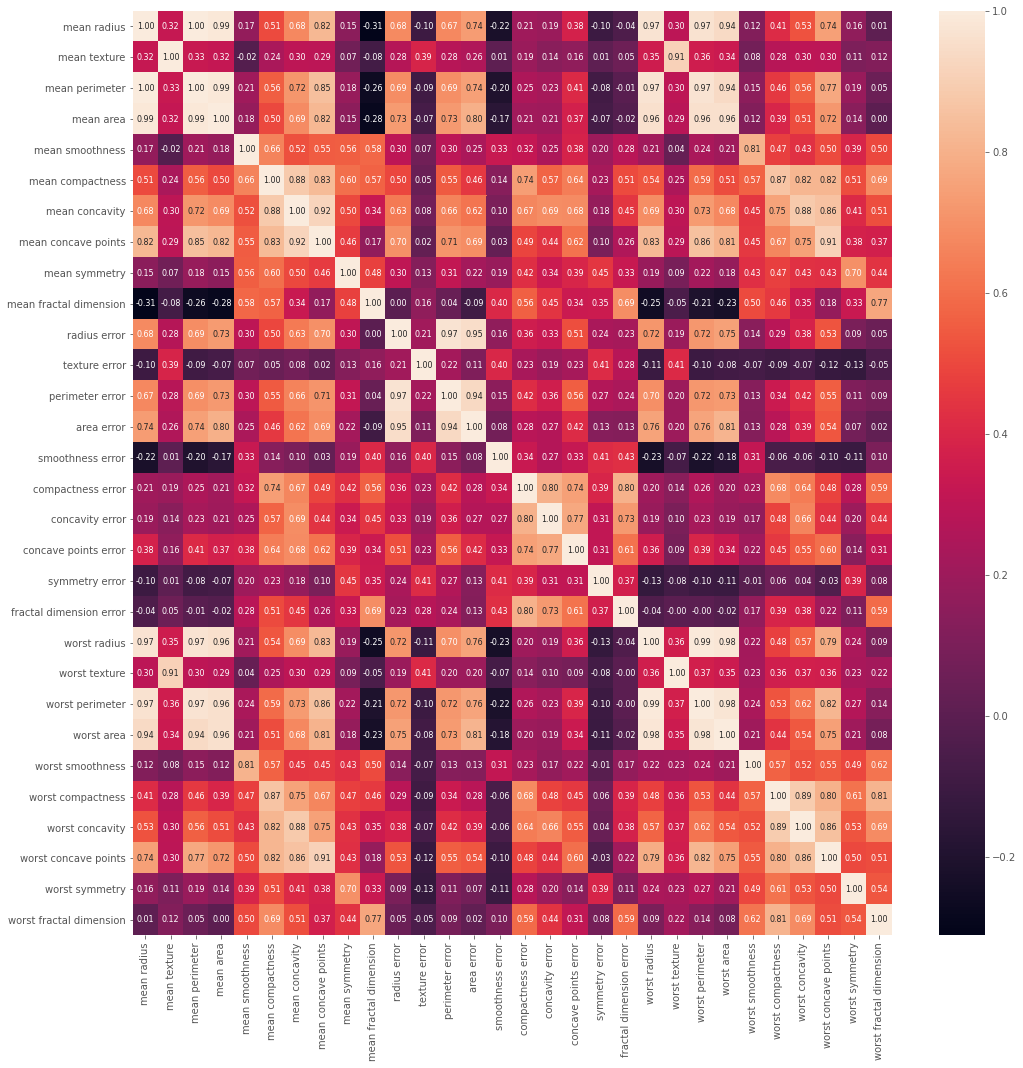

In [12]:
plt.figure(figsize=(17, 17))
sns.heatmap(correlation, annot=True, fmt='.2f', annot_kws={'fontsize': 8});

Here we saw some features with white color, which means that they have strong correlation. To undestand it better, we will simplify it more by choosing which features with correlation greater than 0.9 or less than -0.9.

In [0]:
strong_pairs = []
for num, (i, row) in enumerate((np.abs(correlation) > 0.9).iterrows()):
    for j, element in row[num:].iteritems():
        if i == j:
            continue
        else:
            if element:
                strong_pairs.append((i, j))

In [14]:
strong_pairs

[('mean radius', 'mean perimeter'),
 ('mean radius', 'mean area'),
 ('mean radius', 'worst radius'),
 ('mean radius', 'worst perimeter'),
 ('mean radius', 'worst area'),
 ('mean texture', 'worst texture'),
 ('mean perimeter', 'mean area'),
 ('mean perimeter', 'worst radius'),
 ('mean perimeter', 'worst perimeter'),
 ('mean perimeter', 'worst area'),
 ('mean area', 'worst radius'),
 ('mean area', 'worst perimeter'),
 ('mean area', 'worst area'),
 ('mean concavity', 'mean concave points'),
 ('mean concave points', 'worst concave points'),
 ('radius error', 'perimeter error'),
 ('radius error', 'area error'),
 ('perimeter error', 'area error'),
 ('worst radius', 'worst perimeter'),
 ('worst radius', 'worst area'),
 ('worst perimeter', 'worst area')]

Above, we have a list of tuples with each tuple contains two features that have strong coefficient of determination. Later, we will see if there any differences for our metrics performance with or without these features.

---

## Base Predictive Modeling

In this section, we will perform predictive modeling without hyperparameter tuning and preprocessing step to let us know how they would be beneficial for our quest to get the best model. But, before we step right into it, let's split the data into training set and validation set. We won't use the validation set up until we get the best model, this set will be used for final check only.

In [0]:
# split the data with stratify argument 
# to make sure our splitted data represent the true full data
X_train, X_valid, y_train, y_valid = train_test_split(bunch.data, bunch.target, test_size=0.2, stratify=bunch.target)

In [0]:
# We will populate this dictionary with scores for each step we go through
reports = dict()

### LogisticRegression

In [0]:
lr = LogisticRegression(random_state=RANDOM_STATE)
logistic_default_cv_scores = custom_cross_val(lr, X_train, y_train)

In [17]:
prettify_scores(logistic_default_cv_scores)

accuracy  : [0.97802198 0.91208791 0.89010989 0.93406593 0.95604396] ---> Mean : 0.9340659340659341
recall    : [0.98245614 0.92982456 0.96491228 0.96491228 0.98245614] ---> Mean : 0.9649122807017545
precision : [0.98245614 0.92982456 0.87301587 0.93220339 0.94915254] ---> Mean : 0.9333305013947297
f1        : [0.98245614 0.92982456 0.91666667 0.94827586 0.96551724] ---> Mean : 0.9485480943738656
roc_auc   : [0.99793602 0.98503612 0.98039216 0.98503612 0.99535604] ---> Mean : 0.9887512899896802


Even without parameter tuning and preprocessing step the score for all five metrics are awesomely good. Note that because we are dealing with cancer problem (or any illness problem) our focus will be on recall score because we want to minimize false negative. We don't want people with illness uncaught.

### SGDClassifier

In [18]:
sgd_clf = SGDClassifier(random_state=RANDOM_STATE)
sgd_default_scores = custom_cross_val(sgd_clf, X_train, y_train)
prettify_scores(sgd_default_scores)

accuracy  : [0.91208791 0.96703297 0.86813187 0.87912088 0.91208791] ---> Mean : 0.9076923076923077
recall    : [1.         1.         0.94736842 0.9122807  0.94736842] ---> Mean : 0.9614035087719298
precision : [0.87692308 0.95       0.85714286 0.89655172 0.91525424] ---> Mean : 0.8991743790984001
f1        : [0.93442623 0.97435897 0.9        0.90434783 0.93103448] ---> Mean : 0.9288335025425496
roc_auc   : [0.96852425 0.99742002 0.94169247 0.93240454 0.96800826] ---> Mean : 0.9616099071207429


Scores for Stochastic Gradient Descent Classifier are certainly lower than LogisticRegression.

### GaussianNB

In [19]:
gauss_nb = GaussianNB()
gauss_default_scores = custom_cross_val(gauss_nb, X_train, y_train)
prettify_scores(gauss_default_scores)

accuracy  : [0.98901099 0.92307692 0.91208791 0.91208791 0.92307692] ---> Mean : 0.9318681318681319
recall    : [1.         0.96491228 0.92982456 0.98245614 0.94736842] ---> Mean : 0.9649122807017543
precision : [0.98275862 0.91666667 0.92982456 0.88888889 0.93103448] ---> Mean : 0.929834644081468
f1        : [0.99130435 0.94017094 0.92982456 0.93333333 0.93913043] ---> Mean : 0.9467527235032955
roc_auc   : [1.         0.9871001  0.97626419 0.98090815 0.9871001 ] ---> Mean : 0.9862745098039216


A bit lower than LogisticRegression's scores but higher than SGDClassifiers.

### KNeighborsClassifier

In [20]:
knn = KNeighborsClassifier()
knn_default_scores = custom_cross_val(knn, X_train, y_train)
prettify_scores(knn_default_scores)

accuracy  : [0.94505495 0.92307692 0.87912088 0.9010989  0.91208791] ---> Mean : 0.9120879120879121
recall    : [0.94736842 0.9122807  0.94736842 0.98245614 0.94736842] ---> Mean : 0.9473684210526315
precision : [0.96428571 0.96296296 0.87096774 0.875      0.91525424] ---> Mean : 0.9176941312944594
f1        : [0.95575221 0.93693694 0.90756303 0.92561983 0.93103448] ---> Mean : 0.931381298401153
roc_auc   : [0.99251806 0.9752322  0.93292054 0.90841073 0.98348813] ---> Mean : 0.9585139318885447


For KNeighborsClassifier, we get recall score better than 3 previous models. Even though all other scores are still lower than Logistic's scores.

### LinearSVC

In [21]:
linear_svc = LinearSVC(random_state=RANDOM_STATE)
linear_svc_default_scores = custom_cross_val(linear_svc, X_train, y_train)
prettify_scores(linear_svc_default_scores)

accuracy  : [0.89010989 0.95604396 0.86813187 0.9010989  0.89010989] ---> Mean : 0.9010989010989011
recall    : [1.         1.         0.98245614 0.89473684 0.85964912] ---> Mean : 0.9473684210526315
precision : [0.85074627 0.93442623 0.8358209  0.94444444 0.96078431] ---> Mean : 0.9052444303714472
f1        : [0.91935484 0.96610169 0.90322581 0.91891892 0.90740741] ---> Mean : 0.9230017332805742
roc_auc   : [0.98348813 0.99535604 0.96078431 0.95562436 0.98142415] ---> Mean : 0.9753353973168213


We get a larger recall score. Note for LogisticRegression and LinearSVC, the training step stops before convergence happened. Therefore, we have to set the hyperparameter max_iter larger.

### SVC

In [22]:
svc = SVC(random_state=RANDOM_STATE)
svc_default_scores = custom_cross_val(svc, X_train, y_train)
prettify_scores(svc_default_scores)

accuracy  : [0.93406593 0.93406593 0.89010989 0.87912088 0.91208791] ---> Mean : 0.9098901098901099
recall    : [1.         0.98245614 0.96491228 1.         0.98245614] ---> Mean : 0.9859649122807017
precision : [0.9047619  0.91803279 0.87301587 0.83823529 0.88888889] ---> Mean : 0.8845869495339119
f1        : [0.95       0.94915254 0.91666667 0.912      0.93333333] ---> Mean : 0.9322305084745762
roc_auc   : [0.99226006 0.98090815 0.9504644  0.94788442 0.97213622] ---> Mean : 0.9687306501547986


### DecisionTreeClassifier

In [23]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_default_scores = custom_cross_val(dt, X_train, y_train)
prettify_scores(dt_default_scores)

accuracy  : [0.96703297 0.92307692 0.93406593 0.92307692 0.95604396] ---> Mean : 0.9406593406593406
recall    : [0.98245614 0.9122807  0.96491228 1.         0.96491228] ---> Mean : 0.9649122807017545
precision : [0.96551724 0.96296296 0.93220339 0.890625   0.96491228] ---> Mean : 0.9432441749749072
f1        : [0.97391304 0.93693694 0.94827586 0.94214876 0.96491228] ---> Mean : 0.9532373767032991
roc_auc   : [0.96181631 0.92672859 0.92363261 0.89705882 0.95304438] ---> Mean : 0.9324561403508772


### RandomForestClassifier

In [24]:
forest = RandomForestClassifier(random_state=RANDOM_STATE)
forest_default_scores  = custom_cross_val(forest, X_train, y_train)
prettify_scores(forest_default_scores)

accuracy  : [0.97802198 0.97802198 0.94505495 0.94505495 0.92307692] ---> Mean : 0.9538461538461538
recall    : [0.96491228 0.98245614 0.96491228 1.         0.94736842] ---> Mean : 0.9719298245614034
precision : [1.         0.98245614 0.94827586 0.91935484 0.93103448] ---> Mean : 0.9562242647776282
f1        : [0.98214286 0.98245614 0.95652174 0.95798319 0.93913043] ---> Mean : 0.9636468729368177
roc_auc   : [1.         0.99122807 0.99484004 0.96929825 0.99148607] ---> Mean : 0.9893704850361196


### GradientBoostingClassifier

In [25]:
gbc = GradientBoostingClassifier(random_state=RANDOM_STATE)
gbc_default_scores = custom_cross_val(gbc, X_train, y_train)
prettify_scores(gbc_default_scores)

accuracy  : [0.96703297 0.96703297 0.93406593 0.94505495 0.95604396] ---> Mean : 0.9538461538461538
recall    : [0.94736842 0.98245614 0.94736842 1.         0.98245614] ---> Mean : 0.9719298245614034
precision : [1.         0.96551724 0.94736842 0.91935484 0.94915254] ---> Mean : 0.9562786087029002
f1        : [0.97297297 0.97391304 0.94736842 0.95798319 0.96551724] ---> Mean : 0.9635509744320974
roc_auc   : [1.         0.98555212 0.99071207 0.98503612 0.99432405] ---> Mean : 0.991124871001032


---